Setting up the environment...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
✅ Environment setup complete.
Loading GroundingDINO model...
Loading SAM 2 model...
✅ Models loaded successfully.

Running pipeline for prompt: 'a dog.'
✅ Pipeline complete! Displaying result...


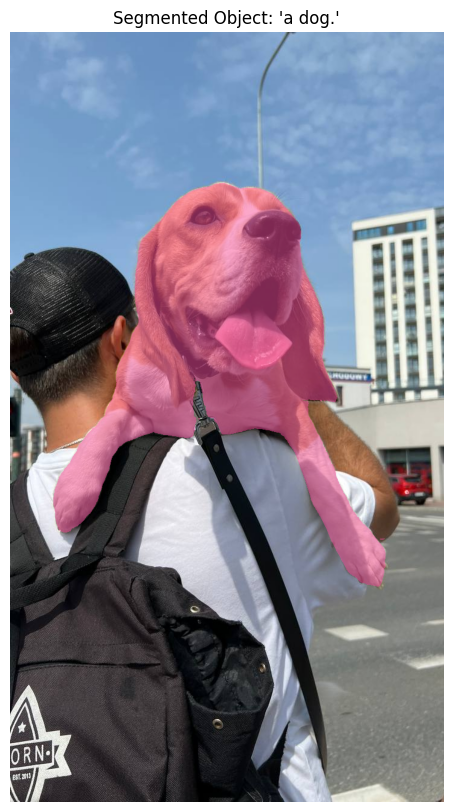

In [ ]:

import os
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

print("Setting up the environment...")


if not os.path.exists('segment-anything-2'):
    !git clone -q https://github.com/facebookresearch/segment-anything-2.git


if os.getcwd().split('/')[-1] != 'segment-anything-2':
    os.chdir('segment-anything-2')

#  dependencies
!pip install -q -e .
!pip install -q transformers supervision # Ensure supervision is installed


import supervision as sv


# checkpoints
if not os.path.exists('checkpoints/sam2_hiera_large.pt'):
    os.makedirs('checkpoints', exist_ok=True)
    !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P checkpoints

print("Environment setup complete.")


from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# grounding dino hugging face
print("Loading GroundingDINO model...")
g_model_id = "IDEA-Research/grounding-dino-tiny"
g_processor = AutoProcessor.from_pretrained(g_model_id)
grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained(g_model_id).to(DEVICE)

# 2. Load Official SAM 2
print("Loading SAM 2 model...")
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint).to(DEVICE)
image_predictor = SAM2ImagePredictor(sam2_model)
print("✅ Models loaded successfully.")

# segmentation
# --- Inputs ---
image_url = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
image_pil = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
text_prompt = "a dog."

# --- Pipeline ---
print(f"\nRunning pipeline for prompt: '{text_prompt}'")
# 1. Get bounding box from text using GroundingDINO
inputs = g_processor(images=image_pil, text=text_prompt, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = grounding_model(**inputs)
results = g_processor.post_process_grounded_object_detection(
    outputs, inputs.input_ids, target_sizes=[image_pil.size[::-1]]
)
boxes = results[0]["boxes"]

# 2. box + sam2 = mask
image_np = np.array(image_pil)
image_predictor.set_image(image_np)
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # This returns a logit mask (an array of numbers)
    masks_logits, _, _ = image_predictor.predict(
        box=boxes.cpu().numpy(),
        multimask_output=False,
    )

#boolean mask to logit mask
masks_bool = (masks_logits > 0.0)

#mask
print(" Pipeline complete! Displaying result...")

# Create the Detections object using the corrected boolean mask
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks_bool),
    mask=masks_bool,
    class_id=np.arange(masks_bool.shape[0])
)

mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(scene=image_np.copy(), detections=detections)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.title(f"Segmented Object: '{text_prompt}'")
plt.axis('off')
plt.show()

In [ ]:

video_url = "https://storage.googleapis.com/gtv-videos-bucket/sample/BigBuckBunny.mp4"

try:
    response = requests.get(video_url, stream=True)
    response.raise_for_status()

    video_path = 'input_video.mp4'
    with open(video_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Video downloaded successfully to {video_path}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading video: {e}")


Video downloaded successfully to input_video.mp4


In [ ]:
import os

video_path = 'input_video.mp4'

if os.path.exists(video_path):
    print(f"Verification successful: Video file '{video_path}' exists.")

else:
    print(f"Verification failed: Video file '{video_path}' not found.")

Verification successful: Video file 'input_video.mp4' exists.


In [ ]:
import cv2
import os

frames_dir = 'extracted_frames'

In [ ]:
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    os.makedirs(frames_dir, exist_ok=True)
    frame_count = 0
    max_frames = 1000
    while True:
        success, frame = video.read()
        if not success or frame_count >= max_frames: #  stop after max_frames
            break
        frame_filename = os.path.join(frames_dir, f'frame_{frame_count:05d}.png')
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    video.release()
    cv2.destroyAllWindows()
    print(f"Successfully extracted {frame_count} frames to {frames_dir}")

Successfully extracted 1000 frames to extracted_frames


Performing initial segmentation on the first frame for prompt: 'a rabbit'
Detected bounding box: [[ 3.2727814e+00 -6.5630436e-01  1.2767355e+03  7.1827075e+02]]
✅ Initial segmentation complete.


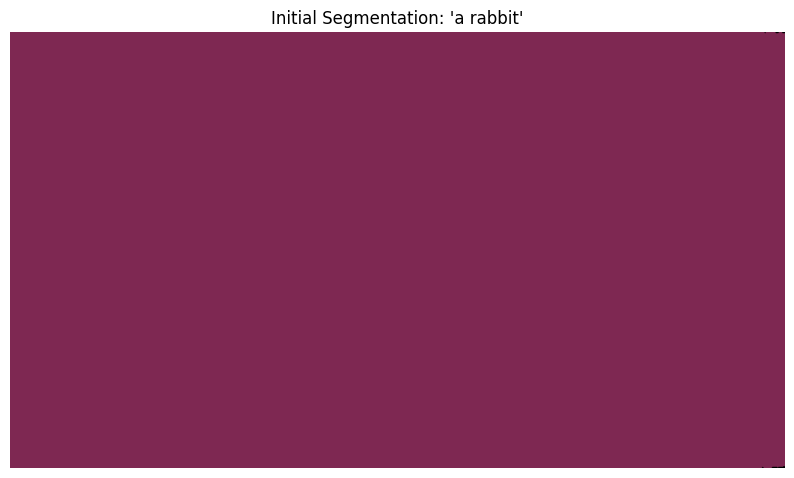

In [ ]:
# Define the path to the first frame
first_frame_path = os.path.join(frames_dir, 'frame_00000.png')

if not os.path.exists(first_frame_path):
    print(f"Error: First frame not found at {first_frame_path}")
else:
    # Load the first frame
    first_frame_pil = Image.open(first_frame_path).convert("RGB")
    first_frame_np = np.array(first_frame_pil)

    # Define the text prompt for segmentation
    # You might want to change this prompt based on the object you want to segment
    text_prompt = "a rabbit"

    print(f"Performing initial segmentation on the first frame for prompt: '{text_prompt}'")

    # 1. Get bounding box from text using GroundingDINO
    inputs = g_processor(images=first_frame_pil, text=text_prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = grounding_model(**inputs)
    results = g_processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, target_sizes=[first_frame_pil.size[::-1]]
    )
    boxes = results[0]["boxes"]

    # Check if any boxes were detected
    if boxes.shape[0] == 0:
        print("No objects detected for the given text prompt in the first frame.")
        initial_mask = None
        initial_boxes = None
    else:
        # Assuming we take the first detected box if multiple are found
        initial_boxes = boxes.cpu().numpy()
        print(f"Detected bounding box: {initial_boxes}")

        # 2. Use the box to get a mask from SAM 2
        image_predictor.set_image(first_frame_np)
        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            masks_logits, _, _ = image_predictor.predict(
                box=initial_boxes,
                multimask_output=False,
            )

        # Convert the logit mask to a boolean mask
        initial_mask = (masks_logits > 0.0)
        print("✅ Initial segmentation complete.")

        # Optional: Display the initial segmentation result
        if initial_mask is not None:
            detections = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=initial_mask),
                mask=initial_mask,
                class_id=np.arange(initial_mask.shape[0])
            )

            mask_annotator = sv.MaskAnnotator()
            annotated_image = mask_annotator.annotate(scene=first_frame_np.copy(), detections=detections)

            plt.figure(figsize=(10, 10))
            plt.imshow(annotated_image)
            plt.title(f"Initial Segmentation: '{text_prompt}'")
            plt.axis('off')
            plt.show()

In [ ]:
# Check if initial_mask was successfully created
if initial_mask is None:
    print("Initial mask was not created. Cannot proceed with mask propagation.")
else:
    propagated_masks = {}
    # Store the initial mask
    propagated_masks[0] = initial_mask

    # Get the list of frame files, sorted by frame number
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.startswith('frame_') and f.endswith('.png')])

    print(f"\nStarting mask propagation for {len(frame_files) - 1} frames...")

    # Iterate through the frames starting from the second frame
    for i in range(1, len(frame_files)):
        current_frame_path = os.path.join(frames_dir, frame_files[i])
        previous_frame_path = os.path.join(frames_dir, frame_files[i-1])

        if not os.path.exists(current_frame_path):
            print(f"Warning: Frame not found at {current_frame_path}. Skipping.")
            continue

        # Load the current and previous frames
        current_frame_pil = Image.open(current_frame_path).convert("RGB")
        current_frame_np = np.array(current_frame_pil)
        previous_frame_pil = Image.open(previous_frame_path).convert("RGB")
        previous_frame_np = np.array(previous_frame_pil)

        # Get the mask from the previous frame
        previous_mask = propagated_masks[i-1]

        # --- Mask Propagation Logic ---
        # This is a simplified approach. More advanced techniques might involve:
        # 1. Using the previous mask as a prompt for SAM 2
        # 2. Using optical flow to estimate mask movement
        # 3. Combining techniques for robustness

        # For this example, we'll use the previous mask's bounding box as a prompt for SAM 2
        # This assumes the object doesn't move drastically between frames.
        previous_boxes = sv.mask_to_xyxy(masks=previous_mask)

        if previous_boxes.shape[0] == 0:
            print(f"Warning: No mask found in previous frame {i-1}. Cannot propagate to frame {i}. Skipping.")
            # If no mask is found, we can either stop, or try to re-initialize with GroundingDINO
            propagated_masks[i] = None # Or handle this case differently
            continue

        # Assuming we use the first box if multiple were generated from the previous mask
        box_prompt = previous_boxes[0][np.newaxis, :] # SAM 2 expects shape (N, 4)

        image_predictor.set_image(current_frame_np)
        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            masks_logits, _, _ = image_predictor.predict(
                box=box_prompt,
                multimask_output=False,
            )

        # Convert the logit mask to a boolean mask
        current_mask = (masks_logits > 0.0)

        # Store the propagated mask
        propagated_masks[i] = current_mask

        # Optional: Print progress
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(frame_files)} frames.")

    print("\n✅ Mask propagation complete.")

Initial mask was not created. Cannot proceed with mask propagation.



Starting visualization of results...


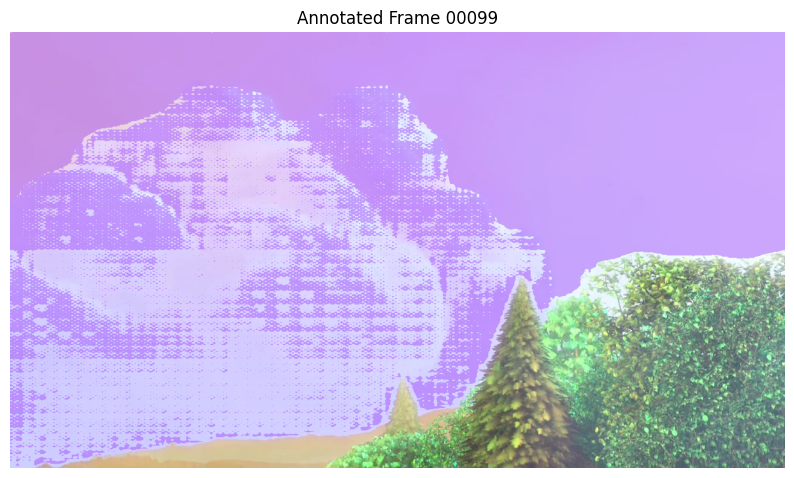

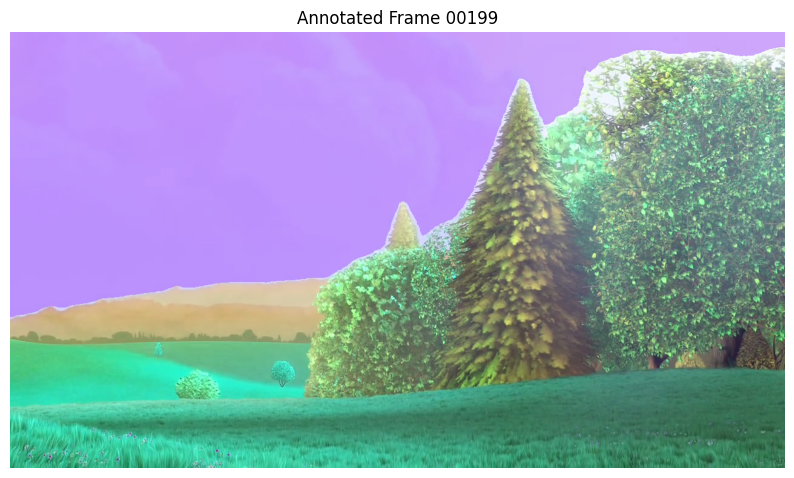

KeyboardInterrupt: 

In [ ]:
# directory to save annotated frames
annotated_frames_dir = 'annotated_frames'
os.makedirs(annotated_frames_dir, exist_ok=True)

print("\nStarting visualization of results...")

# list of frame files, sorted by frame number
frame_files = sorted([f for f in os.listdir(frames_dir) if f.startswith('frame_') and f.endswith('.png')])

#  mask annotator
mask_annotator = sv.MaskAnnotator()

#    propagattion
for i in range(len(frame_files)):
    current_frame_path = os.path.join(frames_dir, frame_files[i])

    if not os.path.exists(current_frame_path):
        print(f"Warning: Frame not found at {current_frame_path}. Skipping visualization for this frame.")
        continue

    # current frame
    current_frame_pil = Image.open(current_frame_path).convert("RGB")
    current_frame_np = np.array(current_frame_pil)

    #  propagated mask for this frame
    current_mask = propagated_masks.get(i)

    if current_mask is None or current_mask.shape[0] == 0:
        print(f"Warning: No mask found for frame {i}. Skipping annotation for this frame.")
        # If no mask, just save the original frame
        annotated_frame_filename = os.path.join(annotated_frames_dir, f'annotated_frame_{i:05d}.png')
        cv2.imwrite(annotated_frame_filename, current_frame_np)
        continue

    # detections object from the mask
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=current_mask),
        mask=current_mask,
        class_id=np.arange(current_mask.shape[0]) # Assign a class_id (can be adjusted)
    )

    # Annotate  frame with the mask
    annotated_image = mask_annotator.annotate(scene=current_frame_np.copy(), detections=detections)


    annotated_frame_filename = os.path.join(annotated_frames_dir, f'annotated_frame_{i:05d}.png')
    cv2.imwrite(annotated_frame_filename, annotated_image)


    if (i + 1) % 100 == 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)) # BGR to RGB
        plt.title(f"Annotated Frame {i:05d}")
        plt.axis('off')
        plt.show()


print("\n✅ Visualization complete! Annotated frames saved to:", annotated_frames_dir)

#

output_video_path = 'segmented_video.mp4'
frame_rate = 30

annotated_frame_files = sorted([f for f in os.listdir(annotated_frames_dir) if f.startswith('annotated_frame_') and f.endswith('.png')])

if annotated_frame_files:
    # Read the first frame to get dimensions
    first_annotated_frame_path = os.path.join(annotated_frames_dir, annotated_frame_files[0])
    first_annotated_frame = cv2.imread(first_annotated_frame_path)
    height, width, layers = first_annotated_frame.shape
    size = (width, height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Or 'XVID'
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, size)

    for annotated_frame_file in annotated_frame_files:
        annotated_frame_path = os.path.join(annotated_frames_dir, annotated_frame_file)
        img = cv2.imread(annotated_frame_path)
        out.write(img)

    out.release()
    print(f"\n✅ Segmented video saved to: {output_video_path}")
else:
    print("\nNo annotated frames found to create a video.")